In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_72951/3657790019.py:22: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


## 0. Data loading

In [3]:
output_dir = "../workdir/carla/iclight_vidtome/routes_town02_04_09_15_40_53_lmr_0.9_gmr_0.8_alpha_t_0.0"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device, dtype=torch.float32)
    # data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids)
elif config.data.scene_type.lower() == "carla":
    from utils.dataparsers import CarlaDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)
    data_parser = CarlaDataParser(config.data, config.device, dtype=torch.float32)
    # data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device, dtype=torch.float32)
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-21 20:25:54.305176: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 20:25:54.319077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745238354.336332   72951 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745238354.341515   72951 cuda_b

[INFO] frame indexes:  0 1 ... 298 299


Loading Data: 100%|██████████| 417/417 [00:28<00:00, 14.84it/s]


[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
[INFO] frame size (900, 1600) resize to (540, 960) and centercrop to (536, 960)
please consider installing flash attention for faster inference
MemFlowNet_skflow
no flash attention installed
[Using basicencoder as context encoder]
[Using basicencoder as feature encoder]
[Using GMA-SK2]
[Using corr_fn default]
[Loading ckpt from /data1/yang_liu/python_workspace/IC-Light/models/memflow/MemFlowNet_things.pth]


/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(cfg.restore_ckpt, map_lo

[INFO] Saving future flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/future_flow_memflow as .pt files
[INFO] Saving past flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/past_flow_memflow as .pt files
[INFO] Saving target flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/target_flow_memflow as .pt files
[INFO] Saving src flows to ../data/carla/sim2real_2_6/data_collect_town02_results/routes_town02_04_09_15_40_53/rgb_front/src_flow_memflow as .pt files


Loading Flows:   0%|          | 0/300 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers/video_dataparser.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this 

[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)
[INFO] frame size (536, 960) resize to (536, 960) and centercrop to (536, 960)


Assigning flow ids: 100%|██████████| 299/299 [00:00<00:00, 860.51it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 73662256 / 154368000


In [64]:
from utils.flow_utils import warp_flow

def _get_mask_bwds(org_images, flows, past_flows, alpha=0.1, beta=1.0, diff_threshold=0.1):

    mask_bwds = torch.ones_like(org_images[:, 0])
    fwd2bwd_flow = warp_flow(flows[:-1], past_flows[1:])
    bwd_lr_error = torch.linalg.norm(past_flows[1:] + fwd2bwd_flow, dim=1)
    T_flow = ((torch.linalg.norm(past_flows[1:], dim=1) + torch.linalg.norm(fwd2bwd_flow, dim=1)) + 1) * alpha

    org_images_warp = warp_flow(org_images[:-1], past_flows[1:])
    color_error = (org_images_warp - org_images[1:]).abs().max(dim=1).values
    T_color = org_images.max().item() * diff_threshold

    mask_bwds[1:] = torch.sigmoid(-beta * (bwd_lr_error - T_flow)) * torch.sigmoid(-beta * (color_error - T_color))
    
    return mask_bwds[:, None]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


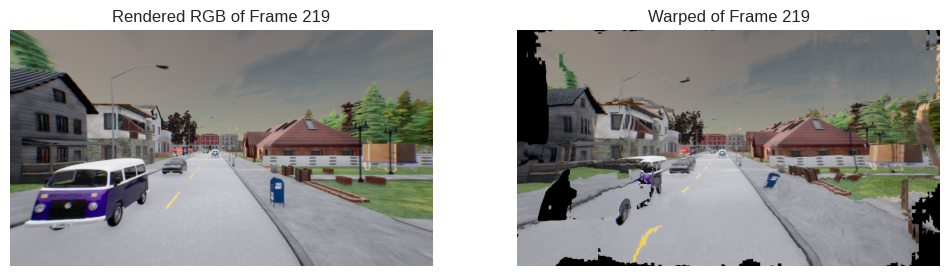

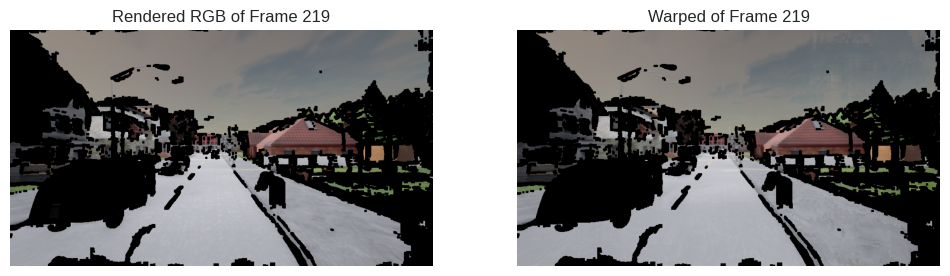

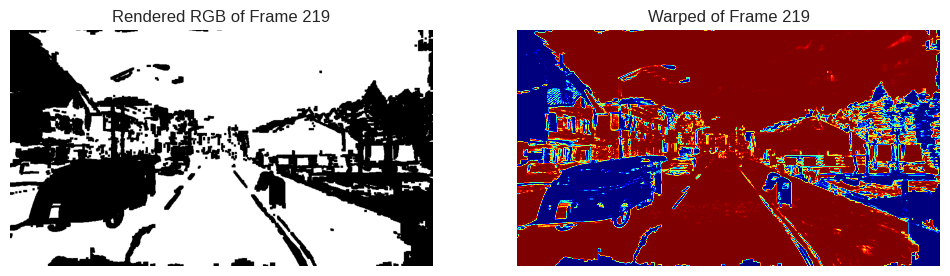

: 

In [73]:
ANALYZE_FLOW_MASK = True
if ANALYZE_FLOW_MASK:
    from utils.flow_utils import warp_flow, get_mask_bwds

    mask_bwds = get_mask_bwds(org_frames, flows, past_flows, alpha=1.0)
    _mask_bwds = _get_mask_bwds(org_frames, flows, past_flows, alpha=1.0, beta=100)
    idx = random.randint(1, len(org_frames)-1)
    idx = 219

    image, pre_image = org_frames[idx:idx+1], org_frames[idx-1:idx]
    past_flow = past_flows[idx:idx+1]
    warped_image = warp_flow(pre_image, past_flow)
    warped_image_m = warped_image * mask_bwds[idx:idx+1].float()
    image_m = image * mask_bwds[idx:idx+1].float()

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(warped_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Warped of Frame {idx}")
    plt.axis("off")

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image_m[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(warped_image_m[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Warped of Frame {idx}")
    plt.axis("off")

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_bwds[idx].float().permute(1, 2, 0).detach().cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(_mask_bwds[idx].permute(1, 2, 0).detach().cpu().numpy(), cmap='jet')
    plt.title(f"Warped of Frame {idx}")
    plt.axis("off")